In [1]:
# File Directory 
import glob
import os
from os.path import isdir, join
from pathlib import Path

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
import librosa

# Dimension Reduction
from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display
'''import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls'''

# Data Pre-processing
import pandas as pd
from sklearn.model_selection import KFold
import soundfile

# Deep Learning
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import Input, layers
#from tensorflow.keras import backend as K
import cv2

# Configuration
#py.init_notebook_mode(connected=True)

from keras.activations import relu, softmax
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras import losses, models, optimizers
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras import backend as K

%matplotlib inline

Using TensorFlow backend.


In [ ]:
samples=[]
labels = []
sample_slice_iteration = 0

gunshot_sound_dir = "C:\\Users\\hosle\\Documents\\_REU2019\\gunshot\\"

for file in os.listdir(gunshot_sound_dir):
    if file.endswith(".wav"):
        sample, sample_rate = librosa.load(gunshot_sound_dir + file)
        if (sample.size <= 44100):
            sample_slice = np.zeros(44100)
            sample_slice[0:sample.size] = sample
            label = 1
            sample_slice_iteration += 1
            if np.max(abs(sample_slice)) < 0.25:
                label = 0

            samples.append(sample_slice)
            labels.append(label)
            
        for i in range(0, sample.size - 44100, 44100):
            sample_slice = sample[i : i + 44100]
            label = 1
            sample_slice_iteration += 1
            if np.max(abs(sample_slice)) < 0.25:
                label = 0

            samples.append(sample_slice)
            labels.append(label)
        
glassbreak_sound_dir = "C:\\Users\\hosle\\Documents\\_REU2019\\glassbreak\\"

print("...Switching to glassbreak sounds...")

for file in os.listdir(glassbreak_sound_dir):
    if file.endswith(".wav"):
        sample, sample_rate = librosa.load(glassbreak_sound_dir + file)
        if (sample.size <= 44100):
            sample_slice = np.zeros(44100)
            sample_slice[0:sample.size] = sample
            label = 0
            sample_slice_iteration += 1
            if np.max(abs(sample_slice)) < 0.5:
                label = 0

            samples.append(sample_slice)
            labels.append(label)
            
        for i in range(0, sample.size - 44100, 44100):
            sample_slice = sample[i : i + 44100]
            label = 0
            sample_slice_iteration += 1
            if np.max(abs(sample_slice)) < 0.5:
                label = 0

            samples.append(sample_slice)
            labels.append(label)

In [ ]:
np.save("samples.npy", samples)
np.save("labels.npy", labels)

In [ ]:
mypath = "C:\\Users\\hosle\\Documents\\_REU2019\\_project\\gunshot_detection\\Train\\"
dr = os.listdir(mypath)
for i in range(len(dr)):
    dr[i] = int(dr[i][:-4])
dr = np.sort(dr)
files = np.zeros(len(dr)).astype('str')
for i in range(len(dr)):
    files[i] = str(dr[i]) + '.wav'
files

In [ ]:
#read in the csv file of descriptors for all other urban sounds
sound_types = pd.read_csv("C:\\Users\\hosle\\Documents\\_REU2019\\_project\\gunshot_detection\\train.csv")
print(sound_types.loc[0,'Class'])

j=0
count = 0
#read in all of the wav files similar to above
urban_sound_dir = "C:\\Users\\hosle\\Documents\\_REU2019\\_project\\gunshot_detection\\Train\\"

for file in files:
    if file.endswith(".wav"):
        count += 1
        sample, sample_rate = librosa.load(urban_sound_dir + file)
        if (count % 100 == 0):
            print (count)
        if (sample.size <= 44100):
            sample_slice = np.zeros(44100)
            sample_slice[0:sample.size] = sample
            if(sound_types.loc[j, 'Class'] == "gun_shot"):
                label = 1
            else:
                label = 0
            sample_slice_iteration += 1
            if np.max(abs(sample_slice)) < 0.25:
                label = 0

            samples.append(sample_slice)
            labels.append(label)


        for i in range(0, sample.size - 44100, 44100):
            sample_slice = sample[i : i + 44100]
            if(sound_types.loc[j, 'Class'] == "gun_shot"):
                label = 1
            else:
                label = 0
            sample_slice_iteration += 1
            if np.max(abs(sample_slice)) < 0.25:
                label = 0

            samples.append(sample_slice)
            labels.append(label)
        j +=1


## Fireworks

In [ ]:
samples = list(np.load("samples.npy"))
labels = list(np.load("labels.npy"))

In [ ]:
sample_slice_iteration = 0

sound_dir = "C:\\Users\\hosle\\Documents\\_REU2019\\_project\\gunshot_detection\\fireworks\\"

for file in os.listdir(sound_dir):
    if file.endswith(".wav"):
        sample, sample_rate = librosa.load(sound_dir + file)
        if (sample.size <= 44100):
            sample_slice = np.zeros(44100)
            sample_slice[0:sample.size] = sample
            label = 0
            sample_slice_iteration += 1
            if np.max(abs(sample_slice)) < 0.25:
                label = 0

            samples.append(sample_slice)
            labels.append(label)
            
        for i in range(0, sample.size - 44100, 44100):
            sample_slice = sample[i : i + 44100]
            label = 0
            sample_slice_iteration += 1
            if np.max(abs(sample_slice)) < 0.25:
                label = 0

            samples.append(sample_slice)
            labels.append(label)

In [ ]:
print(len(samples))
i=450
samp=samples[i]
sr=2050
print(np.max(abs(samp)))
print(labels[i])
ipd.Audio(samp, rate=sr)

In [ ]:
sum(labels)

In [ ]:
np.save("samples.npy", samples)
np.save("labels.npy", labels)

In [ ]:
samples = np.load("samples.npy")
labels = np.load("labels.npy")

## Augment data

In [ ]:
def time_shift(wav):
    start_ = int(np.random.uniform(-4800,4800))
    if start_ >= 0:
        wav_time_shift = np.r_[wav[start_:], np.random.uniform(-0.001,0.001, start_)]
    else:
        wav_time_shift = np.r_[np.random.uniform(-0.001,0.001, -start_), wav[:start_]]
    return wav_time_shift

def speed_change(wav):
    speed_rate = np.random.uniform(0.7,1.3)
    wav_speed_tune = cv2.resize(wav, (1, int(len(wav) * speed_rate))).squeeze()
    #print('speed rate: %.3f' % speed_rate, '(lower is faster)')
    if len(wav_speed_tune) < len(wav):
        pad_len = len(wav) - len(wav_speed_tune)
        wav_speed_tune = np.r_[np.random.uniform(-0.001,0.001,int(pad_len/2)),
                               wav_speed_tune,
                               np.random.uniform(-0.001,0.001,int(np.ceil(pad_len/2)))]
    else: 
        cut_len = len(wav_speed_tune) - len(wav)
        wav_speed_tune = wav_speed_tune[int(cut_len/2):int(cut_len/2)+len(wav)]
    return wav_speed_tune

In [ ]:
samples.shape[0]

In [ ]:
aug_labels = np.zeros((labels.shape[0]*3,))
aug_labels[1]

In [ ]:
aug_samples = np.zeros((samples.shape[0]*3, samples.shape[1]))
aug_labels = np.zeros((labels.shape[0]*3,))
j = 0
for i in range (0, len(aug_samples), 3):
    aug_samples[i,:] = samples[j,:]
    aug_samples[i+1,:] = time_shift(samples[j,:])
    aug_samples[i+2,:] = speed_change(samples[j,:])
    
    aug_labels[i] = labels[j]
    aug_labels[i+1] = labels[j]
    aug_labels[i+2] = labels[j]
    j += 1

In [ ]:
np.save("aug_samples.npy", aug_samples)
np.save("aug_labels.npy", aug_labels)

## Model

In [2]:
from sklearn.preprocessing import LabelBinarizer
samples = np.load("samples.npy")
labels = np.load("labels.npy")

In [3]:
l = []
for i in range(len(labels)):
    if labels[i] == 1:
        l.append('gunshot')
    else:
        l.append('other')

In [4]:
lb = LabelBinarizer()
labels = lb.fit_transform(l)

In [5]:
labels = np.hstack((labels, 1 - labels))
labels

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [6]:
kf = KFold(n_splits=3, shuffle=True)
'''samples = aug_samples #np.array(samples)
labels = aug_labels #np.array(labels)'''

#labels = keras.utils.to_categorical(labels, 2)
for train_index, test_index in kf.split(samples):
    print("TRAIN:", train_index, "TEST:", test_index)
    train_wav, test_wav = samples[train_index], samples[test_index]
    train_label, test_label = labels[train_index], labels[test_index]

TRAIN: [   1    3    6 ... 6374 6375 6377] TEST: [   0    2    4 ... 6370 6372 6376]
TRAIN: [   0    1    2 ... 6375 6376 6377] TEST: [   6   10   11 ... 6366 6371 6374]
TRAIN: [   0    2    4 ... 6372 6374 6376] TEST: [   1    3    7 ... 6373 6375 6377]


In [7]:
def show(data):
    plt.figure(figsize=(12, 4))
    librosa.display.waveplot(data, sr = 16000)

[0 1]


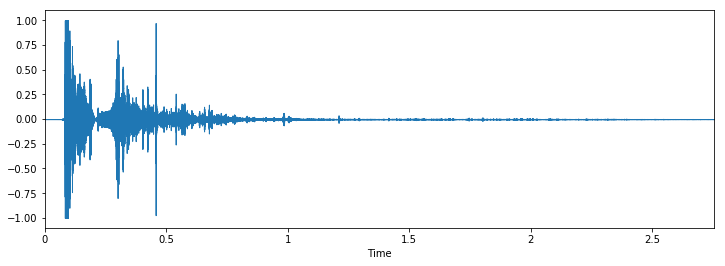

In [8]:
d = 0
print(labels[d])
show(samples[d,:])

In [9]:
# Parameters
lr = 0.001
generations = 20000
num_gens_to_wait = 250
batch_size = 32
drop_out_rate = 0.2
input_shape = (44100,1)

In [10]:
#For Conv1D add Channel
train_wav = np.array(train_wav)
test_wav = np.array(test_wav)
train_wav = train_wav.reshape(-1,44100,1)
test_wav = test_wav.reshape(-1,44100,1)
#train_label = keras.utils.to_categorical(train_label, 2)
#test_label = keras.utils.to_categorical(test_label, 2)

In [11]:
print(train_label[0])
print(test_label[0])

[0 1]
[0 1]


### ROC AUC metric used. Make sure to use the import: from keras import backend as K for a Keras network

In [12]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [16]:
input_tensor = Input(shape=input_shape)
nclass = 2

x = Convolution1D(16, 9, activation=relu, padding="same")(input_tensor)
x = Convolution1D(16, 9, activation=relu, padding="same")(x)
x = MaxPool1D(16)(x)
x = Dropout(rate=0.1)(x)

x = Convolution1D(32, 3, activation=relu, padding="same")(x)
x = Convolution1D(32, 3, activation=relu, padding="same")(x)
x = MaxPool1D(8)(x)
x = Dropout(rate=0.1)(x)

x = Convolution1D(128, 3, activation=relu, padding="same")(x)
x = Convolution1D(128, 3, activation=relu, padding="same")(x)
x = GlobalMaxPool1D()(x)
x = Dropout(rate=0.2)(x)

x = Dense(64, activation=relu)(x)
x = Dense(1028, activation=relu)(x)
output_tensor = Dense(nclass, activation=softmax)(x)

model = models.Model(inputs=input_tensor, outputs=output_tensor)
opt = optimizers.Adam(0.001, 0.001 / 100)

model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=[auc, 'acc'])

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 44100, 1)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 44100, 16)         160       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 44100, 16)         2320      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 2756, 16)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2756, 16)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 2756, 32)          1568      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 2756, 32)          3104      
__________

In [18]:
model_filename = '1Dcnngunglass.pkl' 
callbacks = [
    EarlyStopping(monitor='val_auc',
                  patience=10,
                  verbose=1,
                  mode='max'),
    
    ModelCheckpoint(model_filename, monitor='val_auc',
                    verbose=1,
                    save_best_only=True,
                    mode='max'),
]

In [19]:
model.fit(train_wav, train_label, 
          validation_data=[test_wav, test_label],
          batch_size=batch_size,
          callbacks = callbacks,
          epochs=100,
          verbose=1)

Train on 4252 samples, validate on 2126 samples
Epoch 1/100
4252/4252 [==============================] - 16s 4ms/step - loss: 0.2064 - auc: 0.9429 - acc: 0.9287 - val_loss: 0.0945 - val_auc: 0.9777 - val_acc: 0.9652

Epoch 00001: val_auc improved from -inf to 0.97767, saving model to 1Dcnngunglass.pkl
Epoch 2/100
4252/4252 [==============================] - 12s 3ms/step - loss: 0.1015 - auc: 0.9857 - acc: 0.9603 - val_loss: 0.1018 - val_auc: 0.9880 - val_acc: 0.9671

Epoch 00002: val_auc improved from 0.97767 to 0.98799, saving model to 1Dcnngunglass.pkl
Epoch 3/100
4252/4252 [==============================] - 13s 3ms/step - loss: 0.0871 - auc: 0.9899 - acc: 0.9675 - val_loss: 0.0811 - val_auc: 0.9908 - val_acc: 0.9690

Epoch 00003: val_auc improved from 0.98799 to 0.99078, saving model to 1Dcnngunglass.pkl
Epoch 4/100
 992/4252 [=====>........................] - ETA: 7s - loss: 0.0718 - auc: 0.9915 - acc: 0.9728

KeyboardInterrupt: 

### Validation

In [298]:
model.load_weights("1Dcnngunglass.pkl")

In [390]:
mypath = "C:\\Users\\hosle\\Downloads\\Metal Bang-SoundBible.com-672025076.wav"
#mypath = "C:\\Users\\hosle\\Documents\\_REU2019\\extra\\320134.wav"
#mypath = "C:\\Users\\hosle\\Documents\\_REU2019\\_project\\gunshot_detection\\fireworks\\56608__syna-max__fireworks-well-i-guess-you-missed-it.wav"

fire, sr = librosa.load(mypath)

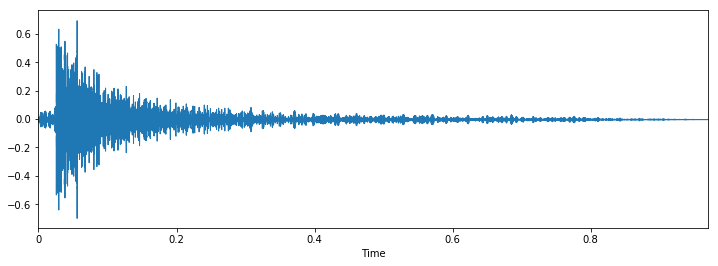

In [391]:
show(fire)

In [392]:
validation = []
if (fire.size <= 44100):
    sample_slice = np.zeros(44100)
    sample_slice[0:fire.size] = fire
    validation.append(sample_slice)

for i in range(0, fire.size - 44100, 44100):
    sample_slice = fire[i : i + 44100]
    validation.append(sample_slice)
    
validation = np.array(validation)
validation_1 = validation.reshape(-1,44100,1)

In [393]:
val_pred = model.predict(validation_1)

In [394]:
val_pred1 = lb.inverse_transform(val_pred[:, 0])
print(len(val_pred1))

1


In [395]:
np.argwhere(val_pred1 == 'gunshot')

array([[0]], dtype=int64)

[0.13116647 0.8688335 ]
gunshot


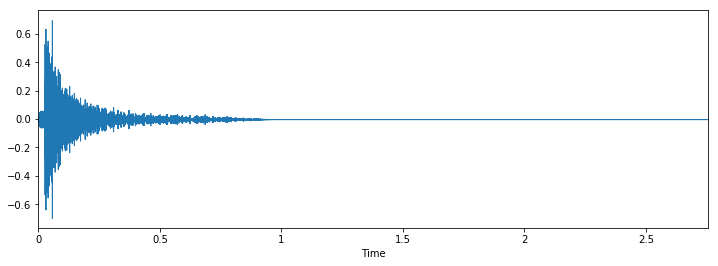

In [396]:
#[0, 1] = gunshot
i = 0
print(val_pred[i, :])
print(val_pred1[i])
show(validation [i])
ipd.Audio(validation [i], rate=22050)

In [32]:
labels

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
Y_test_pred = model.predict(test_wav)
y_predicted_classes_test = Y_test_pred.argmax(axis=-1)
y_actual_classes_test= test_label.argmax(axis=-1)
wrong_examples = np.nonzero(y_predicted_classes_test != y_actual_classes_test)

In [ ]:
print(wrong_examples)
y_test = test_label

In [ ]:
i=2012
samp=np.reshape(test_wav[i],44100,)
sr=22050
print(y_test[i],Y_test_pred[i])
ipd.Audio(samp, rate=sr)

In [ ]:
i=5
samp=np.reshape(test_wav[i],44100,)
sr=22050
print(y_test[i],Y_test_pred[i])
ipd.Audio(samp, rate=sr)

In [ ]:
i=19
samp=np.reshape(test_wav[i],44100,)
sr=22050
print(y_test[i],Y_test_pred[i])
ipd.Audio(samp, rate=sr)

In [ ]:
i=41
samp=np.reshape(test_wav[i],44100,)
sr=22050
print(y_test[i],Y_test_pred[i])
ipd.Audio(samp, rate=sr)

In [ ]:
i=504
samp=np.reshape(test_wav[i],44100,)
sr=22050
print(y_test[i],Y_test_pred[i])
ipd.Audio(samp, rate=sr)

In [268]:
lb = LabelBinarizer()

In [272]:
lb.fit_transform([1, 3, 2])

array([[1, 0, 0],
       [0, 0, 1],
       [0, 1, 0]])